In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
def reduced_form(a, b, c, alpha, beta, gamma, normalized=True):
    '''
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4844519/
    '''
    
    if normalized:
        b = b / a
        c = c / a
        a = 1
    
    a2 = a ** 2
    b2 = b ** 2
    c2 = c ** 2
    
    bc = b * c * np.cos(np.radians(alpha))
    ac = a * c * np.cos(np.radians(beta))
    ab = a * b * np.cos(np.radians(gamma))
    
    return torch.tensor([[a2, b2, c2], [bc, ac, ab]])


def get_lattice_vectors(a, b, c, alpha, beta, gamma):
    '''
    http://gisaxs.com/index.php/Unit_cell
    '''
    
    alpha = np.radians(alpha)
    beta = np.radians(beta)
    gamma = np.radians(gamma)
    
    # a 
    a1 = a
    a2 = 0
    a3 = 0
    
    # b
    b1 = b * np.cos(gamma)
    b2 = b * np.sin(gamma)
    b3 = 0
    
    # c
    c1 = c * np.cos(beta)
    c2 = c * (np.cos(alpha) - np.cos(beta)*np.cos(gamma)) / np.sin(gamma)
    c3 = c * np.sqrt(1 - np.cos(beta)**2 - ((np.cos(alpha) - np.cos(beta)*np.cos(gamma)) / np.sin(gamma))**2)

    a_ = np.array([a1, a2, a3])
    b_ = np.array([b1, b2, b3])
    c_ = np.array([c1, c2, c3])
    
    return a_, b_, c_


def hessenberg_form(A):
    ''' 
    Tridiagonalize A to upper Hessenberg form using Householder reflections.
    '''
    
    m, n = A.shape

    for k in range(m - 1):
        vk = A[(k + 1):, k]
        vk[0] += torch.sign(vk[0]) * torch.linalg.norm(vk, 2)
        vk /= torch.linalg.norm(vk, 2)
        A[(k + 1):, k:] -= 2 * torch.outer(vk, torch.matmul(vk, A[(k + 1):, k:]))
        A[:, (k + 1):] -= 2 * torch.outer(torch.matmul(A[:, (k + 1):], vk), vk)

    return torch.triu(A, -1)


def schur_form(A, tol=1e-10):
    '''
    Schur form of A using Wilkinson shifted QR algorithm.
    '''
    
    # tridiagonalize input to a Hessenberg matrix.
    T = hessenberg_form(A)
    
    m, n = T.shape
    
    m -= 1
    mu = 0
    
    while m > 0:
        # initialize shift
        mu_matrix = torch.eye(T.shape[0]) * mu
        # perform QR decomposition on the shifted matrix.
        Q, R = torch.linalg.qr(T - mu_matrix)
        # multiply R and Q and shift the matrix back.
        T = torch.matmul(R, Q) + mu_matrix
        # Wilkinson shift
        delta = (T[m - 1, m - 1] - T[m, m]) / 2
        mu = T[m, m] - torch.sign(delta) * T[m, m - 1] ** 2 / \
             (torch.abs(delta) + torch.sqrt(delta ** 2 + T[m, m - 1] ** 2))
        # check convergence
        if torch.abs(T[m, m - 1]) < tol:
            m -= 1
    return T



In [3]:
a = torch.rand(3,3)
print(schur_form(a))

# from functorch import vmap
# a = torch.rand(5,3,3)
# vmap(schur_form)(a)

# b = [schur_form(i) for i in a
# b = torch.stack(b, dim=0) ]

tensor([[ 2.0052e+00, -3.1475e-01,  3.5645e-01],
        [ 7.0893e-17, -6.7179e-01,  2.8389e-01],
        [ 0.0000e+00, -2.3538e-09,  4.1755e-01]])


In [4]:
EPS = 1e-6

class VNLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(VNLinear, self).__init__()
        self.map_to_feat = nn.Linear(in_features, out_features, bias=False)
    
    def forward(self, x):
        '''
        x: point features of shape [B, N_feat, 3, N_samples, ...]
        '''
        x_out = self.map_to_feat(x.transpose(1,-1)).transpose(1,-1)
        return x_out


class VNReLU(nn.Module):
    def __init__(self, in_features, negative_slope=0.2):
        super(VNReLU, self).__init__()
        self.map_to_dir = nn.Linear(in_features, in_features, bias=False)
        self.negative_slope = negative_slope
    
    def forward(self, x):
        '''
        x: point features of shape [B, N_feat, 3, N_samples, ...]
        '''
        d = self.map_to_dir(x.transpose(1,-1)).transpose(1,-1)
        dotprod = (x*d).sum(2, keepdim=True)
        mask = (dotprod >= 0).float()
        d_norm_sq = (d*d).sum(2, keepdim=True)
        x_out = self.negative_slope * x + (1-self.negative_slope) * (mask*x + (1-mask)*(x-(dotprod/(d_norm_sq+EPS))*d))
        return x_out


class VNBatchNorm(nn.Module):
    def __init__(self, num_features):
        super(VNBatchNorm, self).__init__()
        self.bn = nn.BatchNorm1d(num_features)
    
    def forward(self, x):
        '''
        x: point features of shape [B, N_feat, 3, N_samples, ...]
        '''
        norm = torch.norm(x, dim=2) + EPS
        norm_bn = self.bn(norm)
        norm = norm.unsqueeze(2)
        norm_bn = norm_bn.unsqueeze(2)
        x = x / norm * norm_bn
        return x
    

class VNInvariantFeature(nn.Module):
    def __init__(self, feature_dim, negative_slope=0.2):
        super(VNInvariantFeature, self).__init__()
        self.vn_layer_1 = nn.Sequential(
            VNLinear(feature_dim, feature_dim//2),
            VNBatchNorm(feature_dim//2),
            VNReLU(feature_dim//2, negative_slope))
        self.vn_layer_2 = nn.Sequential(
            VNLinear(feature_dim//2, feature_dim//4),
            VNBatchNorm(feature_dim//4),
            VNReLU(feature_dim//4, negative_slope))
        self.vn_lin = nn.Linear(feature_dim//4, 3, bias=False)
    
    def forward(self, x):
        '''
        x: point features of shape [B, N_feat, 3, N_samples, ...]
        '''
        x_equ = self.vn_layer_1(x)
        x_equ = self.vn_layer_2(x_equ)
        x_equ = self.vn_lin(x_equ.transpose(1, -1)).transpose(1, -1)
        x_equ = x_equ.transpose(1, 2)
        x_inv = torch.einsum('bijm,bjkm->bikm', x, x_equ)
        return x_inv

In [5]:
class Encoder(nn.Module):
    def __init__(self, in_dim, negative_slope=0.0):
        super(Encoder, self).__init__()
        self.snn = nn.Sequential(
            nn.Linear(in_dim, in_dim//4),
            nn.BatchNorm1d(in_dim//4),
            nn.ReLU(),
            nn.Linear(in_dim//4, 3*3))
        self.vnn = nn.Sequential(
            VNLinear(1, 32),
            VNBatchNorm(32),
            VNReLU(32, negative_slope),
            VNLinear(32, 64),
            VNBatchNorm(64),
            VNReLU(64, negative_slope))
        self.std_feature = VNInvariantFeature(64*2, negative_slope)
        self.vnn_to_out = VNLinear(64*2, 1)  
        
    def forward(self, x):
        # scalar network to a,b,c
        x = self.snn(x)
        
        # reshape to [B, N_feat, 3, N_samples]
        # N_samples=3 for 3 primitive lattice vectors a,b,c
        B, D, N = x.shape[0], 3, 3
        x = x.view(B, 1, D, N)
        
        # SO(3) equivariant vector network 
        x = self.vnn(x)
        
        # SO(3) invariant features (sec 3.5 paper)
        x_mean = x.mean(dim=-1, keepdim=True).expand(x.size())
        x = torch.cat((x, x_mean), 1)
        x = self.std_feature(x)
        
        x = self.vnn_to_out(x)
        x = x.squeeze(1)
        return x

    
def test():
    x = torch.randn((100, 1000))
    model = Encoder(1000)
    x_hat = model(x)
    print(x_hat.shape)
test()

torch.Size([100, 3, 3])


In [6]:
rootdir = './material.pkl'

id = []
xrd = np.empty([41100,1000])
params = np.empty([41100,6])

with open(rootdir, 'rb') as f:
    material = pickle.load(f)
    for i, k in enumerate(material.keys()):
        id.append(k)
        xrd[i] = np.array(material[k]['xrd'])[0]
        params[i] = np.array(material[k]['param'])

In [7]:
abc = np.empty([41100,3,3])

for i, param in enumerate(params):
    a, b, c = get_lattice_vectors(
        param[0], 
        param[1],
        param[2],
        param[3],
        param[4],
        param[5])
    
    abc[i][:,0] = a
    abc[i][:,1] = b
    abc[i][:,2] = c

In [12]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(Dataset, self).__init__()
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.X[idx], self.y[idx]
    
    
X, y = xrd, abc
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
dataset = Dataset(X, y)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024)
dataloaders = {'Train': trainloader, 'Val': testloader}

In [13]:
def mse(y, y_pred):
    return nn.MSELoss(reduction='mean')(y, y_pred)

In [18]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = Encoder(in_dim=1000).to(device)

train_loss_list = []
test_loss_list = []

for epoch in range(1, 40 + 1):

    # split epochs into training and validation phase
    for phase in ['Train', 'Val']:
        if phase == 'Train':
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
            model.train(True)
        else:
            model.train(False)

        # mini batch training
        train_loss = 0
        test_loss = 0
        for batch, (X, y) in enumerate(dataloaders[phase]):
            optimizer.zero_grad()

            X, y = X.float(), y.float()
            X, y = X.to(device), y.to(device)
            
            # forward propagation
            y_pred = model(X)
            
            loss = mse(y, y_pred)
            train_loss += loss.item()
            test_loss += loss.item()

            # optimization step only in training phase
            if phase == 'Train':
                loss.backward()
                optimizer.step()

                # print progress
                if batch == len(trainloader) - 1:
                    print('Epoch: {}, Train Loss: {:.3f}'.format(
                        epoch,
                        train_loss / len(trainloader)))
                    train_loss_list.append(train_loss / len(trainloader))
                    train_loss = 0
            
            else:
                if batch == len(testloader) - 1:
                    print('Epoch: {}, Test Loss: {:.3f}'.format(
                        epoch,
                        test_loss / len(testloader)))
                    test_loss_list.append(test_loss / len(testloader))
                    test_loss = 0

Epoch: 1, Train Loss: 28.989
Epoch: 1, Test Loss: 28.724
Epoch: 2, Train Loss: 28.891
Epoch: 2, Test Loss: 28.646
Epoch: 3, Train Loss: 28.876
Epoch: 3, Test Loss: 29.470
Epoch: 4, Train Loss: 28.975
Epoch: 4, Test Loss: 28.898
Epoch: 5, Train Loss: 28.897
Epoch: 5, Test Loss: 29.394
Epoch: 6, Train Loss: 28.816
Epoch: 6, Test Loss: 28.955
Epoch: 7, Train Loss: 28.991
Epoch: 7, Test Loss: 29.126
Epoch: 8, Train Loss: 28.809
Epoch: 8, Test Loss: 28.839
Epoch: 9, Train Loss: 28.850
Epoch: 9, Test Loss: 29.078
Epoch: 10, Train Loss: 28.690
Epoch: 10, Test Loss: 29.018
Epoch: 11, Train Loss: 28.790
Epoch: 11, Test Loss: 28.487
Epoch: 12, Train Loss: 28.845
Epoch: 12, Test Loss: 28.725
Epoch: 13, Train Loss: 29.082
Epoch: 13, Test Loss: 28.921
Epoch: 14, Train Loss: 28.802
Epoch: 14, Test Loss: 29.074
Epoch: 15, Train Loss: 28.799
Epoch: 15, Test Loss: 29.263
Epoch: 16, Train Loss: 28.685
Epoch: 16, Test Loss: 29.197


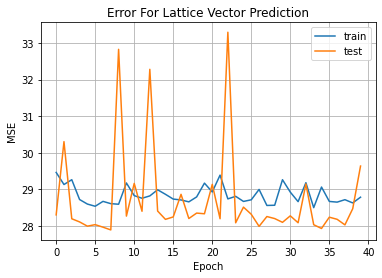

In [17]:
# plot average MSE over all iterations
plt.title("Error For Lattice Vector Prediction")
plt.plot(train_loss_list, label='train')
plt.plot(test_loss_list, label='test')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid()
plt.legend()